In [1]:
import torch
import time
import yaml
import random
import os
import sys
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
sys.path.append('/mnt/weka/scratch/yang.liu3/pyworkspace/3DGS')

import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import makedirs
from scene import Scene
from gaussian_renderer import render
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams

In [2]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def contract_to_unisphere(
        x: torch.Tensor,
        aabb: torch.Tensor,
        ord: float = 2,
        eps: float = 1e-6,
        derivative: bool = False,
    ):
        aabb_min, aabb_max = torch.split(aabb, 3, dim=-1)
        x = (x - aabb_min) / (aabb_max - aabb_min)
        x = x * 2 - 1  # aabb is at [-1, 1]
        mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
        mask = mag.squeeze(-1) > 1

        if derivative:
            dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
                1 / mag**3 - (2 * mag - 1) / mag**4
            )
            dev[~mask] = 1.0
            dev = torch.clamp(dev, min=eps)
            return dev
        else:
            x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
            x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
            return x

## 1. Render with render()

In [3]:
config = '../config/vox_mc_aerial_block3_avg.yaml'
iteration = 15_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)

config_name = os.path.splitext(os.path.basename(config))[0]
lp.model_path = os.path.join("output/", config_name)

In [4]:
with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    # lp.source_path = os.path.join("..", lp.source_path)
    lp.source_path = os.path.join("..", "data/matrix_city/aerial/test/block_3_test")
    lp.model_path = os.path.join("..", lp.model_path)
    scene = Scene(lp, gaussians, load_iteration=iteration, shuffle=False)
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

Loading trained model at iteration 15000
Reading camera 19/19
Loading Training Cameras
[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1
Loading Test Cameras


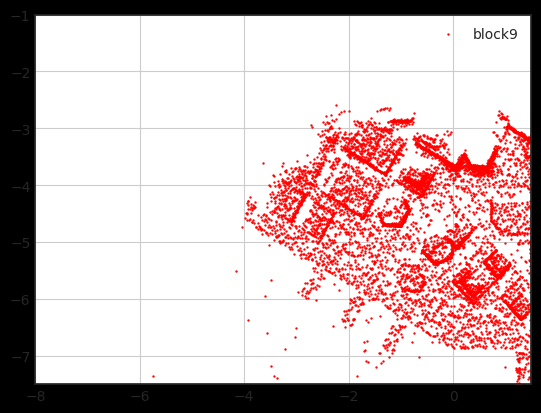

In [5]:
plt.figure()
plt.style.use('seaborn-white')

plt.scatter(gaussians.get_xyz[::100, 0].detach().cpu(), gaussians.get_xyz[::100, 1].detach().cpu(), s=0.5, c='r', label='block9')
# plt.axis('equal')
plt.xlim(-8, 1.5)
plt.ylim(-7.5, -1)
plt.legend()
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


render time: 0.012639999389648438s


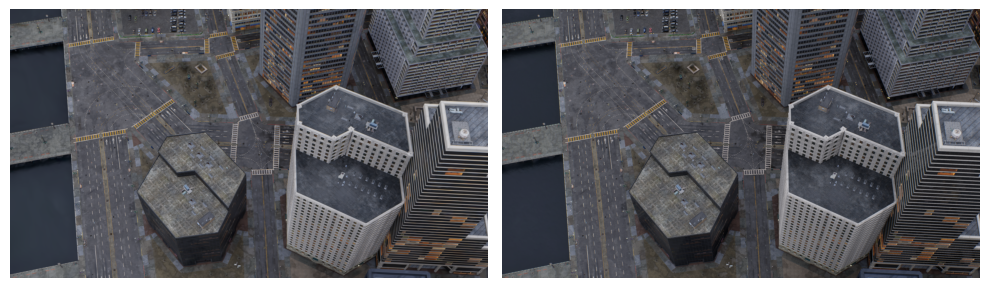

In [6]:
img_opt = 'points'  # 'depths', 'points'
with torch.no_grad():
    idx = random.randint(0, len(views)-1)
    view = views[idx]
    start = time.time()
    render_pkg = render(view, gaussians, pp, background)
    end = time.time()
    print("render time: {}s".format(end-start))
    image = render_pkg["render"].cpu().numpy().transpose(1,2,0)
    gt_image = view.original_image.cpu().numpy().transpose(1,2,0)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.axis(False)
plt.imshow(image)
plt.subplot(122)
plt.axis(False)
plt.imshow(gt_image)
plt.tight_layout()

## 2. Render with render_v2()

In [3]:
from scene.datasets import GSDataset
from scene import LargeScene
from gaussian_renderer import render_v2

In [9]:
config = '../config/block_mc_aerial_block_all_lr_c36_loss_5.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
# lp.source_path = os.path.join("../", lp.source_path)
# lp.model_path = os.path.join("../output/", config_name)
# lp.pretrain_path = os.path.join("../", lp.pretrain_path)

# lp.block_id = 16
lp.source_path = os.path.join("../", "data/matrix_city/aerial/test/block_all_test")
lp.model_path = os.path.join("../output/", "block_mc_aerial_block_all_lr_c36_loss_5_cell12")

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    # scene = LargeScene(lp, gaussians, shuffle=False)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Loaded {lp.model_path}\n')

Loading trained model at iteration 30000
Reading camera 741/741
Loaded ../output/block_mc_aerial_block_all_lr_c36_loss_5_cell12



In [12]:
xy_range = [-3.5, -4, 4.5, 2]
block_dim = [6, 6, 1]

with torch.no_grad():
    xyz_org = gaussians.get_xyz
    aabb = torch.tensor([xy_range[0], xy_range[1], xyz_org[:, -1].min(), 
                        xy_range[2], xy_range[3], xyz_org[:, -1].max()], device='cuda')
    xyz = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)

render time: 0.0158538818359375s


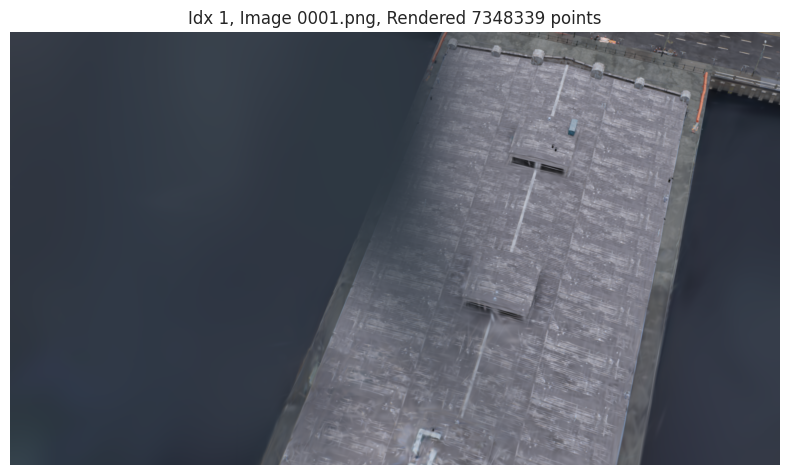

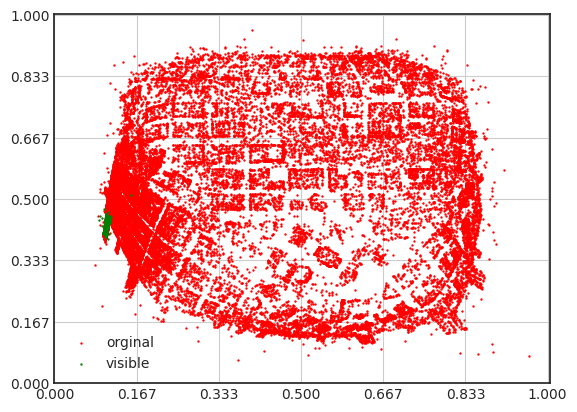

In [13]:
with torch.no_grad():
    # range free for block 9
    # interplay: 1517, 1114, 1538, 884, 849, 1535, 1532, 1264, 106, 99, 55
    # low quality: 1148, 916, 1560, 907

    # range free for block all
    # interplay: 
    # low quality: 101
    idx = random.randint(0, len(gs_dataset)-1)
    idx = 1

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    cam_info, gt_image = gs_dataset[idx]
    image_name = os.path.split(gs_dataset.cameras[idx].image_path)[1]
    start = time.time()
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    end = time.time()
    print("render time: {}s".format(end-start))
    image = render_pkg["render"]

    image = image.cpu().numpy().transpose(1,2,0)

    # show render results
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Idx {idx}, Image {image_name}, Rendered {render_pkg['radii'].shape[0]} points")
    plt.axis(False)
    plt.tight_layout()
    plt.show()

    # show visible points
    plt.figure()
    plt.style.use('seaborn-white')
    visibility_filter = render_pkg["visibility_filter"].cpu().numpy()
    plt.scatter(xyz[::200, 0].detach().cpu(), xyz[::200, 1].detach().cpu(), s=0.5, c='r', label='orginal')
    plt.scatter(xyz[visibility_filter][::200, 0].detach().cpu(), xyz[visibility_filter][::200, 1].detach().cpu(), s=0.5, c='g', label='visible')
    # plt.xlim(-11, 11)
    # plt.ylim(-8, 7)
    plt.xticks(np.linspace(0,1,block_dim[0]+1,endpoint=True))
    plt.yticks(np.linspace(0,1,block_dim[1]+1,endpoint=True))
    plt.legend()
    plt.grid(True)
    plt.show()